## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
i = 0 #counter for saving images

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    raw_img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # Undistort the image 
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1],None, None)
        undistorted = cv2.undistort(raw_img, mtx, dist, None, mtx)
        
        # Display the chessboard corners and undistorted images 
        plt.figure()
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Distorted Image', fontsize=50)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=50)
        
        # Save the figures
        i = i + 1
        figname = 'undistorted_{}.png'.format(i)
        dest = os.path.join('../output_images/undistorted_chessboard_images/', figname)
        plt.savefig(dest)
        plt.close('all') #un/comment here to see the plot inline

## Create a thresholded binary image

In [2]:
# Absolute threshold function
def abs_sobel_thresh(gray, orient = 'x', grad_thresh = (0,255)):
    
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
        
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
        
    scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel)) # scaled to 8-bit (range 0-255)
    
    # Create a binary mask
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    return binary_output

# Magnitude threshold function
def mag_thresh(gray, sobel_kernel = 3, mag_thresh=(0,255)):
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint(255*mag_sobel/np.max(mag_sobel)) # scaled to 8-bit (range 0-255)
    
    # Create a binary mask
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output


# Direction threshold function
def dir_thresh(gray, sobel_kernel = 3, dir_thresh=(0,np.pi/2)):
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    # Create a binary mask
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    return binary_output

def color_thresh(hls, color_thresh = (0,255)):
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    return binary_output

### 1. Using combined thresholds (gradient, magnitude, direction)

In [3]:
images = glob.glob('../test_images/straight_lines*.jpg')
ksize = 15
i = 0 #counter for saving images

for fname in images:
    
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    gradx_binary = abs_sobel_thresh(gray, orient='x', grad_thresh = (20,200))
    grady_binary = abs_sobel_thresh(gray, orient='y', grad_thresh = (20,200))
    mag_binary = mag_thresh(gray, sobel_kernel = ksize, mag_thresh=(30, 200))
    dir_binary = dir_thresh(gray, sobel_kernel = ksize, dir_thresh=(0.7, 1.0))

    combined = np.zeros_like(dir_binary)
    combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Plot the result
    plt.figure()
    f, axs = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    axs[0].imshow(image)
    axs[0].set_title('Original Image', fontsize=50)
    axs[1].imshow(combined, cmap='gray')
    axs[1].set_title('Combined Thresholds', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Save the figures
    i = i + 1
    figname = 'combined_thresh_{}.png'.format(i)
    dest = os.path.join('../output_images/combined_threshold', figname)
    plt.savefig(dest)
    plt.close('all')

### 2. Using combined color and gradient thresholds

In [4]:
images = glob.glob('../test_images/test*.jpg')
i = 2 #counter for saving images

for fname in images:
    
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    gradx_binary = abs_sobel_thresh(hls[:,:,1], orient='x', grad_thresh = (20,200))
    color_binary = color_thresh(hls, color_thresh = (170,255))

    combined = np.zeros_like(gradx_binary)
    combined[(gradx_binary == 1) | (color_binary == 1)] = 1
    
    # Plot the result
    plt.figure()
    f, axs = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    axs[0].imshow(image)
    axs[0].set_title('Original Image', fontsize=50)
    axs[1].imshow(combined, cmap='gray')
    axs[1].set_title('Combined Thresholds', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Save the figures
    i = i + 1
    figname = 'color_gradient_{}.png'.format(i)
    dest = os.path.join('../output_images/color_gradient/', figname)
    plt.savefig(dest)
    plt.close('all') #un/comment here to see the plot inline

## Rectify binary image using a perspective transform

In [5]:
# Masking (select a region of interest)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

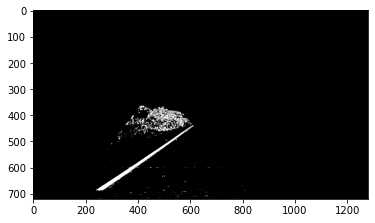

In [6]:
image = mpimg.imread('../test_images/straight_lines1.jpg')
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
ysize = img.shape[0]

gradx_binary = abs_sobel_thresh(hls[:,:,1], orient = 'x', grad_thresh = (20,200))
color_binary = color_thresh(hls, color_thresh = (170,255))

combined = np.zeros_like(gradx_binary, dtype = np.uint8)
combined[(gradx_binary == 1) | (color_binary == 1)] = 1

top_left = [451,310]
bottom_left = [137,ysize]
top_right = [505,310]
bottom_right = [841,ysize]

vertices = np.array([[top_left,top_right,bottom_right,bottom_left]])
mask_img = region_of_interest(combined, vertices) 
plt.imshow(mask_img,cmap='gray')